Import packages:

In [18]:
import os

from netCDF4 import Dataset, num2date

from copy import copy

import matplotlib as mpl
from matplotlib import gridspec, cm, rcParams, pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.cm import get_cmap
#import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import NaturalEarthFeature

import pandas as pd

import numpy as np
import numpy.ma as ma
import numpy.polynomial.polynomial as poly
from numpy.random import default_rng

from sklearn import preprocessing

from eofs.standard import Eof
from eofs.examples import example_data_path
from eofs.tools.standard import correlation_map, covariance_map

from scipy.linalg import inv, logm, expm
from scipy.signal import detrend
from scipy import stats

import os
from datetime import datetime

from wrf import smooth2d

plt.rcParams["font.family"] = "Times New Roman"
#plt.style.use('ggplot')

Define Data:

In [404]:
#define data
WORKDIR = 'Desktop/Master_Thesis/Data/'
DATA_SET = 'ERA5'
pre='detrended' #detrended
VAR = 'psl', 'gp500', 'tas', 'tp' 
DATA_TYP = 'monthly_means'
DATA_YEARS = '1950_2021' #, '1979_2021'
LOCATION = 'NA'
MONTH = 'year', 'NDJFM', 'NDJFM_seasmean', 'NDJFM_seasmean_5_yrs_runmean', 'NDJFM_seasmean_dry_years_masked', 'NDJFM_seasmean_wet_years_masked', 'NDJFM_seasmean_cold_years_masked', 'NDJFM_seasmean_warm_years_masked','NDJFM_seasmean_dry_years', 'NDJFM_seasmean_wet_years', 'NDJFM_seasmean_cold_years', 'NDJFM_seasmean_warm_years', 'DJF', 'JJA', 'MAM', 'SON', '01','02','03','04','05','06','07','08','09','10','11','12'
DATA_FORMAT = '.nc'
month=MONTH[5]
ind_var=VAR[0]
dep_var=VAR[2]


#change VAR and MONTH for different mean fields
mean_var = VAR[1]
mean_month = MONTH[2]

#select data
    #mean_field
data_mean = os.path.join(WORKDIR, DATA_SET, pre, mean_var, 'data',DATA_SET+'_'+DATA_TYP+'_'+DATA_YEARS+'_'+mean_var+'_'+LOCATION+'_'+mean_month+DATA_FORMAT)
    #predictor
independent_data = os.path.join(WORKDIR, DATA_SET, pre, ind_var, 'data', DATA_SET+'_'+DATA_TYP+'_'+DATA_YEARS+'_'+ind_var+'_'+LOCATION+'_'+month+DATA_FORMAT)
    #predictant
dependent_data = os.path.join(WORKDIR, DATA_SET, pre, dep_var, 'data', DATA_SET+'_'+DATA_TYP+'_'+DATA_YEARS+'_'+dep_var+'_'+LOCATION+'_'+month+DATA_FORMAT)
#do we need to detrend TAS and TP data?

print(independent_data)
print(dependent_data)

Desktop/Master_Thesis/Data/ERA5/detrended/psl/data/ERA5_monthly_means_1950_2021_psl_NA_NDJFM_seasmean_wet_years_masked.nc
Desktop/Master_Thesis/Data/ERA5/detrended/tas/data/ERA5_monthly_means_1950_2021_tas_NA_NDJFM_seasmean_wet_years_masked.nc


Calculate mean field:

In [503]:
mean = mean_field(data=data_mean, mean_var=mean_var, mean_month=mean_month, data_years=DATA_YEARS)

Calculate EOFs:

In [405]:
eofs, varfrac, errors, eigenvalues=EOF_analysis(data=independent_data, ind_var=ind_var, month=month, data_years=DATA_YEARS)

Calculate PCs:

In [406]:
pcs_norm, pcs=calc_pcs_norm(data=independent_data, ind_var=ind_var)

Calculate Correlation:

In [407]:
corr, high_corr=CORR(ind_data=independent_data, ind_var=ind_var, dep_data=dependent_data, dep_var=dep_var, pcs_norm=pcs_norm)

Calculate Regression:

In [409]:
reg=reg(dep_data=dependent_data, dep_var=dep_var, pcs_norm=pcs_norm)

In [412]:
eofs[0] = eofs[0] * -1
#eofs[1] = eofs[1] * -1
eofs[2] = eofs[2] * -1
#eofs[3] = eofs[3] * -1

print(np.shape(pcs))
#  pcs_norm[:][1] = pcs_norm[:][1] * -1
#  pcs_norm[:][2] = pcs_norm[:][2] * -1

#PC1
#print(np.sum(pcs_norm[:][0]))
#pcs_norm[66][0]=pcs_norm[:][0]*-1
#print(np.sum(pcs_norm[:][0]))
#print(pcs_norm[66][0])


#PC2
#print(np.sum(pcs_norm[:][1]))

#pcs_norm[:][1]=pcs_norm[:][1]*-1
#print(np.sum(pcs_norm[:][1]))

#PC3
#print(np.sum(pcs_norm[:][2]))
#pcs_norm[:][2]=pcs_norm[:][2]*-1
#print(np.sum(pcs_norm[:][2]))

#PC4
#print(np.sum(pcs_norm[:][3]))
#pcs_norm[:][3] =pcs_norm[:][3] *-1
#print(np.sum(pcs_norm[:][3]))

#corr[0]=corr[0]*-1
#corr[1]=corr[1]*-1
#corr[2]=corr[2]*-1
#corr[3]=corr[3]*-1

reg[0]=reg[0]*-1
#reg[1]=reg[1]*-1
reg[2]=reg[2]*-1
reg[3]=reg[3]*-1

(18, 4)


Plot Results:

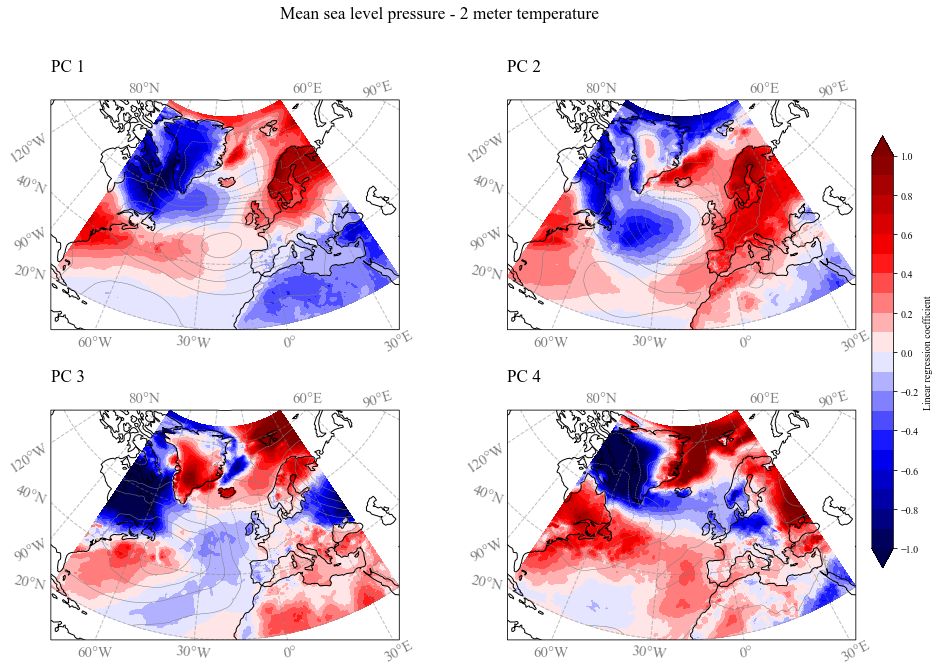

In [413]:
#set file names
saveMFas = os.path.join(WORKDIR, DATA_SET, pre, 'mean_field', mean_var+'_'+DATA_SET+'_'+DATA_TYP+'_'+DATA_YEARS+'_'+LOCATION+'_'+mean_month+'.pdf')
saveSMOOTHas = os.path.join(WORKDIR, DATA_SET, pre, 'mean_field', mean_var+'_smooth_diff_'+DATA_SET+'_'+DATA_TYP+'_'+DATA_YEARS+'_'+LOCATION+'_'+mean_month+'.pdf')
saveEOFas = os.path.join(WORKDIR, DATA_SET, pre, ind_var, 'results', 'EOFs', '4EOFs_'+DATA_YEARS+'_'+ind_var+'_'+month+'.pdf')
savePCas = os.path.join(WORKDIR, DATA_SET, pre, ind_var, 'results', 'PCs','4PCs_'+DATA_YEARS+'_'+ind_var+'_'+month+'.pdf')
saveCORRas = os.path.join(WORKDIR, DATA_SET, pre, ind_var, 'results', 'CORR','4CORR_MAPs_'+DATA_YEARS+'_'+ind_var+'_'+dep_var+'_'+month+'.pdf')
saveREGas = os.path.join(WORKDIR, DATA_SET, pre, ind_var, 'results', 'REG', '4REG_MAPs_'+DATA_YEARS+'_'+ind_var+'_'+dep_var+'_'+month+'.pdf')
savefullREGas = os.path.join(WORKDIR, DATA_SET, pre, ind_var, 'results', 'REG', '4_full_REG_MAPs_'+DATA_YEARS+'_'+ind_var+'_'+dep_var+'_'+month+'.pdf')


#plot & safe
#plot_mean(plotMF=True, saveMF=True, saveMFas=saveMFas, mean=mean, data=data_mean, mean_var=mean_var, mean_month=mean_month, data_years=DATA_YEARS) 
#plot_smooth(plotSMOOTH=True, saveSMOOTH=True, saveSMOOTHas=saveSMOOTHas, data=data_mean, mean_var=mean_var, mean_month=mean_month, data_years=DATA_YEARS) 
#plot_eofs(plotEOFs=True, saveEOFs=False, saveEOFas=saveEOFas, eofs=eofs, varfrac=varfrac, data=independent_data, ind_var=ind_var, month=month, data_years=DATA_YEARS)
#plot_pcs(plotPCs=True, savePCs=False, savePCas=savePCas, pcs_norm=pcs_norm, data=independent_data, ind_var=ind_var, month=month, data_years=DATA_YEARS)
#plot_corr(plotCORR=True, saveCORR=False, saveCORRas=saveCORRas, corr=corr, ind_data=independent_data, ind_var=ind_var, dep_data=dependent_data, dep_var=dep_var, month=month, data_years=DATA_YEARS)
plot_reg(plotREG=True, saveREG=True, saveREGas=savefullREGas, reg=reg, eofs=eofs, high_corr=high_corr, ind_data=independent_data, ind_var=ind_var, dep_data=dependent_data, dep_var=dep_var, month=month, data_years=DATA_YEARS)

# Functions

Mean field:

In [43]:
def mean_field(data, mean_var, mean_month, data_years):

    dataset = Dataset(data)
    var = dataset.variables[mean_var][:]
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    mean_name_long = dataset.variables[mean_var].long_name
    mean_unit = dataset.variables[mean_var].units
    
    #smooth if analysing psl cause noisy at mountain regions
    #calculate mean
    if mean_var == 'psl':
        psl = dataset.variables[mean_var][:]
        var = smooth2d(psl, 3) #https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.smooth2d.html
        mean = var.mean(axis=0)
    else:
        mean = var.mean(axis=0)
        
    return mean

EOF-Analysis:

In [55]:
def EOF_analysis(data, ind_var, month, data_years):
    
    # load data:
    dataset = Dataset(data)
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    tims = dataset.variables['time'][:]
    var = dataset.variables[ind_var][:]
    var_name_long = dataset.variables[ind_var].long_name
    var_unit = dataset.variables[ind_var].units
    dataset.close()
 
    # EOF analysis:
    
    #weight data
   
    wgts = np.sqrt(np.abs(np.cos(np.radians(lats))))[..., np.newaxis]
    
    solver = Eof(var, weights = wgts)
    
    #calc eofs
    
    n = 4
    
    eofs = solver.eofs(neofs = n, eofscaling=0) # , eofscaling=0
    varfrac = solver.varianceFraction(n)
    errors = solver.northTest(neigs=n, vfscaled=True)
    eigenvalues = solver.eigenvalues(neigs=n)
    
    # flip EOFs:   if pressure in Iceland > pressure at Azores for EOF 1
#    ice_lat_in, ice_lon_in = np.where(np.isclose(lats,65,atol=0.3)), np.where(np.isclose(lons,-22.7,atol=0.3))
#    azo_lat_in, azo_lon_in = np.where(np.isclose(lats,37.7,atol=0.3)), np.where(np.isclose(lons,-25.7,atol=0.35))
    
#    ice_lat_in = ice_lat_in[0]
#    ice_lon_in = ice_lon_in[0]
#    azo_lat_in = azo_lat_in[0]
#    azo_lon_in = azo_lon_in[0]

#    if (eofs[0,ice_lat_in[0], ice_lon_in[0]] > eofs[0,azo_lat_in[0], azo_lon_in[0]]):
    #    eofs[0] = eofs[0] * -1   # flip EOFs to get the pattern right 
 #       eofs[0] = eofs[0] * -1
       # pcs = pcs * -1     # also flip PCs then

                         
    return eofs, varfrac, errors, eigenvalues

PC-Calculation:

In [228]:
def calc_pcs_norm(data, ind_var):
    
    # load data:
    ncin = Dataset(data)
    variables = ncin.variables
    lats = ncin.variables['lat'][:]
    lons = ncin.variables['lon'][:]
    tims = ncin.variables['time'][:]
    var = ncin.variables[ind_var][:]
    ncin.close()
    
    #weight data
    coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    
    #load solver
    
    solver = Eof(var, weights = wgts)
    
    #calc pcs
    
    
    n = 4
  
    pcs = solver.pcs(npcs = n)
    eofs = solver.eofs(neofs = n, eofscaling=0)
    
    #normalize pcs

    sums = np.zeros(len(pcs))
    pcs_norm = np.zeros([len(pcs),n])

    for month in range(len(pcs)):
        #print(pcs[month,:])
        sums[month] = np.sum(abs(pcs[month,:]))
        pcs_norm[month] = pcs[month,:] / sums[month]
        #print(np.sum(abs(pcs_norm[month])))
        #print(np.sum(abs(pcs[month,:])))
       
    
    return pcs_norm, pcs

Calculate Correlation:

In [164]:
def CORR(ind_data, ind_var, dep_data, dep_var, pcs_norm):
    
    # load independent data:
    inddatain = Dataset(ind_data)
    lats = inddatain.variables['lat'][:]
    lons = inddatain.variables['lon'][:]
    tims = inddatain.variables['time'][:]
    i_var = inddatain.variables[ind_var][:]
    inddatain.close()
    
    #load dependent data:
    
    depdatain = Dataset(dep_data)
    lats = depdatain.variables['lat'][:]
    lons = depdatain.variables['lon'][:]
    tims = depdatain.variables['time'][:]
    d_var = depdatain.variables[dep_var][:]
    depdatain.close()
     
    # EOF analysis:
    
    coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
    wgts = np.sqrt(coslat)[..., np.newaxis]
    
    solver = Eof(i_var, weights = wgts)
    
    # calculate anomalies of dependent var:
    
    d_mean = d_var.mean(axis=0)
    d_anoms = d_var - d_mean

 #   pcs = calc_pcs_norm(data=ind_data, ind_var=ind_var)
    corr = correlation_map(pcs_norm, d_anoms)
    
    high_corr = ma.masked_inside(corr, -0.4, 0.4)
    
    return corr, high_corr

Calculate Regression:

In [408]:
def reg(dep_data, dep_var, pcs_norm):
    
    d_dat = Dataset(dep_data)
    lats = d_dat.variables['lat'][:]
    lons = d_dat.variables['lon'][:]
    tims = d_dat.variables['time'][:]
    d_var = d_dat.variables[dep_var][:]
    d_dat.close()
    
    #calc dep anomalies 
    d_mean = d_var.mean(axis=0)
    d_anom = d_var - d_mean
    
    #calc std of PCs
 
    pcs_norm_std = pcs_norm.std()
    
    #calc exp_coeff # expansion coefficient are PCs or also EOF Amplitude, PC time series, and PC scores
    
    exp_coeff=pcs_norm/pcs_norm_std
 
    #calc reg

    reg=np.zeros((4,261, 481)) # anomaly associated with 1 std dev in P1
    
    for i in range (4):
        for lat in range(261):
            for lon in range(481):
                sub = np.squeeze(d_anom[:,lat,lon])
                fit = np.polynomial.polynomial.polyfit(exp_coeff[:,i],sub,1)
                reg[i,lat,lon] = fit[1]
    
    return reg

Plot Mean:

In [48]:
def plot_mean(plotMF, saveMF, saveMFas, mean, data, mean_var, mean_month, data_years):
    
    dataset = Dataset(data)
    var = dataset.variables[mean_var][:]
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    mean_name_long = dataset.variables[mean_var].long_name
    mean_unit = dataset.variables[mean_var].units
    
    #plot mean field
    
    if plotMF:
        fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': ccrs.EquidistantConic(central_longitude=-20.0)})

        plt.contourf(lons, lats, mean, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.grid(False)
        cbar = plt.colorbar()
        cbar.set_label('Anomalie '+mean_name_long+' ['+mean_unit+']')
        plt.title('Mean field '+mean_var+' ('+data_years+') '+mean_month)

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
        #gl.xlabels_top = False
        gl.right_labels = False
        #gl.xlines = False
        #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 15, 'color': 'gray'}
        gl.ylabel_style = {'size': 15, 'color': 'gray'}
    
    if saveMF:
        fig.savefig(saveMFas, format='pdf')    

Plot difference between smoothed and non-smoothed data:

In [30]:
def plot_smooth(plotSMOOTH, saveSMOOTH, saveSMOOTHas, data, mean_var, mean_month, data_years):

    dataset = Dataset(data)
    var = dataset.variables[mean_var][:]
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    mean_name_long = dataset.variables[mean_var].long_name
    mean_unit = dataset.variables[mean_var].units
    
    #smooth data
    get_var = dataset.variables[mean_var][:]
    var_smooth = smooth2d(get_var, 3)
    
    #calc mean
    
    mean = var.mean(axis=0)
    mean_smooth = var_smooth.mean(axis=0)
    
    smooth_diff = mean_smooth - mean

    #plot difference between smoothed and non-smoothed psl

    if plotSMOOTH:
        fig, ax = plt.subplots(figsize=(7,5), subplot_kw={'projection': ccrs.EquidistantConic(central_longitude=-20.0)})

        plt.contourf(lons, lats, smooth_diff, transform=ccrs.PlateCarree())
        ax.coastlines()
        ax.grid(False)
        cbar = plt.colorbar()
        cbar.set_label(mean_var+'-smooth - '+mean_var+' ['+mean_unit+'] ')
        plt.title('Anomalie '+mean_var+'-smooth - '+mean_var+' ('+data_years+')')

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
        #gl.xlabels_top = False
        gl.right_labels = False
        #gl.xlines = False
        #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 15, 'color': 'gray'}
        gl.ylabel_style = {'size': 15, 'color': 'gray'}

    if saveSMOOTH:
        fig.savefig(saveSMOOTHas)

Plot EOFs:

In [238]:
def plot_eofs(plotEOFs, saveEOFs, saveEOFas, eofs, varfrac, data, ind_var, month, data_years):

    # load data:
    
    dataset = Dataset(data)
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    tims = dataset.variables['time'][:]
    var = dataset.variables[ind_var][:]
    var_name_long = dataset.variables[ind_var].long_name
    var_unit = dataset.variables[ind_var].units
    dataset.close()
    
    if month == 'NDJFM_seasmean':
        seas = ''
    
    if month == 'NDJFM_seasmean_5_yrs_runmean':
        seas = '- 5-year running mean'
        
    if month == 'NDJFM_seasmean_dry_years_masked':
        seas = '- dry quartile'
        
    if month == 'NDJFM_seasmean_wet_years_masked':
        seas = '- wet quartile'
    
    if month == 'NDJFM_seasmean_warm_years_masked':
        seas = '- warm quartile'
        
    if month == 'NDJFM_seasmean_cold_years_masked':
        seas = '- cold quartile'
    
    sum_varfrac = np.sum(varfrac)*100
    sum_varfrac = "%.2f" % sum_varfrac
    
  #  eofs1=ma.masked_inside(eofs, -0.00025, 0.000025)
  #  cmap1 = copy(plt.cm.viridis)
  #  cmap1.set_bad('w', 0.0)
   # eofs[0] = eofs[0] * -1
  #  eofs[1] = eofs[1] * -1
  #  eofs[2] = eofs[2] * -1
  #  eofs[3] = eofs[3] * -1
    
    if plotEOFs:

        fig, axs = plt.subplots(2, 2, figsize=(15,10), subplot_kw={'projection': ccrs.EquidistantConic(central_longitude=-20.0)})

        i = 0
        for row in range(2):
            for col in range(2):
                ax = axs[row, col]
                cbarticks = np.arange(-0.008,0.009,0.001)
                levels = np.linspace(-0.008,0.008,17)
                line_c = ax.contour(lons, lats, eofs[i,:,:], levels=levels, colors=['grey'], linewidths=0.5 ,transform=ccrs.PlateCarree())
                pcm = ax.contourf(lons, lats, eofs[i,:,:], cbarticks, levels=levels, transform=ccrs.PlateCarree(), extend="both", cmap=cm.coolwarm) #, cmap=cm.seismic 
            #    pcm = ax.contourf(lons, lats, eofs[i,:,:], transform=ccrs.PlateCarree())
                ax.coastlines()
                #cbar = fig.colorbar(pcm, ax=ax)
                #cbar.set_label(f'Anomalies of '+var_name_long+' ['+var_unit+'] ')
                ax.set_title(f'EOF {i+1}', loc='left', fontsize='xx-large');
                ax.set_title(f'{varfrac[i]*100:.1f} %', loc='right', fontsize='xx-large');
                i += 1

                gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                gl.xformatter = LONGITUDE_FORMATTER
                gl.yformatter = LATITUDE_FORMATTER
                gl.xlabel_style = {'size': 15, 'color': 'gray'}
                gl.ylabel_style = {'size': 15, 'color': 'gray'}
        
        
        cb_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
        cbar = fig.colorbar(pcm, cax=cb_ax, ticks = cbarticks)
     #   cbar = fig.colorbar(pcm, cax=cb_ax)
        plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.85, 
                            wspace=0.2, 
                            hspace=0.35)
        cbar.set_label(f'Anomalies of '+var_name_long+' ['+var_unit+'] ')

        fig.suptitle(f''+var_name_long+' '+seas+'\n (Explained variance: '+sum_varfrac+' %)', fontsize='xx-large')

    if saveEOFs:
        fig.savefig(saveEOFas, format='pdf') 

Plot PCs:

In [208]:
def plot_pcs(plotPCs, savePCs, savePCas, pcs_norm, data, ind_var, month, data_years):

    # load data:
    dataset = Dataset(data)
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]
    tims = dataset.variables['time'][:]
    var = dataset.variables[ind_var][:]
    var_name_long = dataset.variables[ind_var].long_name
    var_unit = dataset.variables[ind_var].units
    dataset.close()
    
 #   mon=len(pcs_norm[:,1])/71
    mon=len(pcs_norm[:,1])/67 # 5yr running mean
    
    
   
  #  pcs_norm[:][0] = pcs_norm[:][0] * -1
  #  pcs_norm[:][1] = pcs_norm[:][1] * -1
  #  pcs_norm[:][2] = pcs_norm[:][2] * -1
  #  pcs_norm[:][3] = pcs_norm[:][3] * -1
    
    
    if plotPCs:
        fig_PC, axs = plt.subplots(4, 1, figsize=(7,10))

        for row in range(4):
            ax = axs[row]
            clrs = ['red' if (x > 0) else 'blue' for x in pcs_norm[:,row]]
            myxaxis = np.arange(len(pcs_norm[:,row]))
            ax.bar(myxaxis, pcs_norm[:,row].squeeze(), color=clrs)
            ax.set_facecolor('white')
            for spine in ax.spines.values():
                spine.set_color('black')
          #  myticks = np.arange(0,len(myxaxis),5*mon);
            myticks = np.arange(0,len(myxaxis),5*mon); #5yr running mean
          #  mylabels = np.arange(1950,2021,5) 
            mylabels = np.arange(1952,2018,5) #5yr running mean
            ax.set_xticks(ticks=myticks); 
            ax.set_xticklabels(labels=mylabels);
            ax.set_ylim([-1.0, 1.0])
           # ax.vlines(myticks, ymin=min(pcs[:,0]), ymax=max(pcs[:,0]), colors='grey', linestyles='dashed')
           # ax.set(xlabel='months')
            ax.margins(x=0.005, y=0)
            ax.set_title(f'Normalized PC {row+1}', loc='left', fontsize='xx-large');

        fig_PC.tight_layout()
        
    if savePCs:
        fig_PC.savefig(savePCas, format='pdf') 

Plot Corr:

In [329]:
def plot_corr(plotCORR, saveCORR, saveCORRas, corr, ind_data, ind_var, dep_data, dep_var, month, data_years):

     # load independent data:
    inddatain = Dataset(ind_data)
    lats = inddatain.variables['lat'][:]
    lons = inddatain.variables['lon'][:]
    tims = inddatain.variables['time'][:]
    i_var = inddatain.variables[ind_var][:]
    i_var_name_long = inddatain.variables[ind_var].long_name
    i_var_unit = inddatain.variables[ind_var].units
    inddatain.close()
    
    #load dependent data:
    depdatain = Dataset(dep_data)
    lats = depdatain.variables['lat'][:]
    lons = depdatain.variables['lon'][:]
    tims = depdatain.variables['time'][:]
    d_var = depdatain.variables[dep_var][:]
    d_var_name_long = depdatain.variables[dep_var].long_name
    d_var_unit = depdatain.variables[dep_var].units
    depdatain.close()
     
    if plotCORR:
        
        fig, axs = plt.subplots(2, 2, figsize=(15,10), subplot_kw={'projection': ccrs.EquidistantConic(central_longitude=-20.0)})

        i = 0
        for row in range(2):
            for col in range(2):
                ax = axs[row, col]
                cbarticks = np.arange(-1.0,1.02,0.2)
                levels = np.linspace(-1.,1.,11)
           #     ax = fig.add_axes([0.95, -1.0, 0.02, 1.0])
                pcm = ax.contourf(lons, lats, corr[i,:,:],cbarticks, levels=levels, transform=ccrs.PlateCarree(), cmap=cm.coolwarm)
                ax.coastlines()
                line_c = ax.contour(lons, lats, eofs[i,:,:], colors=['w'], linewidths=0.5 ,transform=ccrs.PlateCarree())


        #        cbar = fig.colorbar(pcm, ax=ax)
        #        cbar.set_label(f'Correlation coefficient')
                #cbar.set_label(f'Anomalies of sea level pressure [Pa]  ')
                #ax.set_title(f'EOF {i+1} ({varfrac[i]*100:.1f} %)')
                ax.set_title(f'PC {i+1}', loc='left', fontsize='x-large');
        #        ax.set_title(f'{varfrac[i]*100:.1f} %', loc='right', fontsize='xx-large');
                i += 1

                gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                #gl.xlines = False
                #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
                gl.xformatter = LONGITUDE_FORMATTER
                gl.yformatter = LATITUDE_FORMATTER
                gl.xlabel_style = {'size': 15, 'color': 'gray'}
                gl.ylabel_style = {'size': 15, 'color': 'gray'}


      #  cb_ax = fig.add_axes([0.95, -1.0, 0.02, 1.0])
       
        cb_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
        cbar = fig.colorbar(pcm, cax=cb_ax, ticks = cbarticks)
        plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.85, 
                            wspace=0.2, 
                            hspace=0.35)
        cbar.set_label(f'r')
     #   cbar.set_label(f'Correlation coefficent ')
#Correlation of 4 main EOFs of MSLP and 
        fig.suptitle(f''+i_var_name_long+' - '+d_var_name_long+'', fontsize='xx-large')
    #plt.show()
        if saveCORR:
            fig.savefig(saveCORRas, format='pdf') 

Plot Reg:

In [410]:
def plot_reg(plotREG, saveREG, saveREGas, reg, eofs, high_corr, ind_data, ind_var, dep_data, dep_var, month, data_years):

     # load independent data:
    inddatain = Dataset(ind_data)
    lats = inddatain.variables['lat'][:]
    lons = inddatain.variables['lon'][:]
    tims = inddatain.variables['time'][:]
    i_var = inddatain.variables[ind_var][:]
    i_var_name_long = inddatain.variables[ind_var].long_name
    i_var_unit = inddatain.variables[ind_var].units
    inddatain.close()
    
    #load dependent data:
    depdatain = Dataset(dep_data)
    lats = depdatain.variables['lat'][:]
    lons = depdatain.variables['lon'][:]
    tims = depdatain.variables['time'][:]
    d_var = depdatain.variables[dep_var][:]
    d_var_name_long = depdatain.variables[dep_var].long_name
    d_var_unit = depdatain.variables[dep_var].units
    depdatain.close()
    
    corr_threshold = 0.4
    hc=np.ones_like(high_corr)
    reg_sig=reg*hc

    if plotREG:
    
        fig, axs = plt.subplots(2, 2, figsize=(15,10), subplot_kw={'projection': ccrs.EquidistantConic(central_longitude=-20.0)})

        i = 0
        for row in range(2):
            for col in range(2):
                ax = axs[row, col]
                #TEMP#
                cbarticks = np.arange(-1.0,1.1,0.2)
                levels = np.linspace(-1.0,1.0,21)
                #PR#
            #    cbarticks = np.arange(-.001,.0011,0.0002)
            #    levels = np.linspace(-.001,.001,21)
                pcm = ax.contourf(lons, lats, reg[i,:,:], cbarticks, levels=levels, transform=ccrs.PlateCarree(), extend="both", cmap=cm.seismic)
            #    pcm = ax.contourf(lons, lats, reg_sig[i,:,:], transform=ccrs.PlateCarree(), cmap=cm.seismic)
                
           #     high_corr_lats = np.array([])
           #     high_corr_lons = np.array([])
           #     for ilat in range(len(lats)):
           #         for ilon in range(len(lons)):
           #             if (high_corr[i,ilat,ilon]>0.4) or (high_corr[i,ilat,ilon]<-0.4):
           #                 high_corr_lats = np.append(high_corr_lats, ilat)
           #                 high_corr_lons = np.append(high_corr_lons, ilon)
                            
           #     for ilat in range(len(lats)):
           #         for ilon in range(len(lons)):
           #             if reg[i,ilat,ilon] == high_corr[i,ilat,ilon]
                            
           #     ax.scatter(x=lons[high_corr_lons.astype(int)], y=lats[high_corr_lats.astype(int)], color="grey", s=0.5, marker='.', 
               #            alpha=0.5, transform=ccrs.PlateCarree(), label=f'Locations with positive/negative correlation > {corr_threshold}')
             #   pcm.legend()
                ax.coastlines() #vmin=-0.0015, vmax=0.0015,
              #  cbar = fig.colorbar(pcm, ax=ax)
              #  cbar.set_label(f'Regression')
                line_c = ax.contour(lons, lats, eofs[i,:,:], colors=['grey'], linewidths=0.5 ,transform=ccrs.PlateCarree())
               # ax.clabel(line_c,fontsize=9, inline=True)
              #  cbar.add_lines(line_c)
                #lbar = fig.colorbar(line_c, ax=ax, ticklocation='left')
                ax.set_title(f'PC {i+1}', loc='left', fontsize='xx-large');
                i += 1

                gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
                gl.top_labels = False
                gl.right_labels = False
                gl.xformatter = LONGITUDE_FORMATTER
                gl.yformatter = LATITUDE_FORMATTER
                gl.xlabel_style = {'size': 15, 'color': 'gray'}
                gl.ylabel_style = {'size': 15, 'color': 'gray'}
        
        cb_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
        cbar = fig.colorbar(pcm, cax=cb_ax, ticks = cbarticks)
        plt.subplots_adjust(left=0.125,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.85, 
                            wspace=0.2, 
                            hspace=0.35)
        cbar.set_label(f'Linear regression coefficient')

        fig.suptitle(f''+i_var_name_long+' - '+d_var_name_long+'', fontsize='xx-large')
    
    if saveREG:
            fig.savefig(saveREGas, format='pdf') 

Eigenvalue Spectrum:

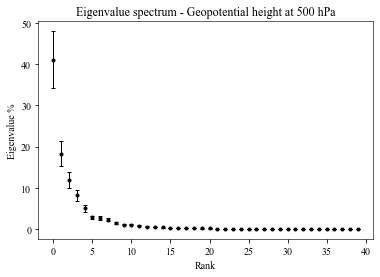

In [12]:

data=independent_data
dataset = Dataset(data)
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]
tims = dataset.variables['time'][:]
var = dataset.variables[ind_var][:]
var_name_long = dataset.variables[ind_var].long_name
var_unit = dataset.variables[ind_var].units
dataset.close()

i=0

n=40

pr_varfrac=np.zeros((n))

for i in range(n):
    pr_varfrac[i]= "%.10f" % varfrac[i]
    pr_varfrac[i]= pr_varfrac[i] * 100

pr_errors=np.zeros((n))
    
for i in range(n):
    pr_errors[i]= "%.10f" % errors[i]
    pr_errors[i]= pr_errors[i] * 100


#sum_eigenvalues = np.sum(eigenvalues)
#pr=eigenvalues/sum_eigenvalues #ergibt genau das gleiche wie varfrac

yerr=pr_errors
myxaxis = np.arange(len(pr_varfrac[:]))

fig = plt.figure()
ax = plt.axes()
ax.errorbar(myxaxis, pr_varfrac[:], yerr=yerr, fmt='o', color='black', ms=3, ecolor='black', elinewidth=1, capsize=2)
ax.set_title('Eigenvalue spectrum - '+var_name_long+'')
plt.xlabel('Rank')
plt.ylabel('Eigenvalue %')
#plt.legend()
ax.set_facecolor('white')  
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.6)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(0.6)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(0.6)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.6)
fig.savefig(os.path.join(WORKDIR, DATA_SET, pre, ind_var, 'results', 'Eigenvalue_spectrum_'+DATA_YEARS+'_'+ind_var+'_'+month+'.pdf'), format='pdf') 

#slicer = slice(0, neigs) --> slice teilt array von Null bis neigs, also 40
## Compute the factor that multiplies the eigenvalues. The number of
## records is assumed to be the number of realizations of the field.
#factor = np.sqrt(2.0 / self._records) --> berechnet den factor lambda(k)^2
## If requested, allow for scaling of the eigenvalues by the total
## variance (sum of the eigenvalues). # sclaing ja, sonst werden die Werte zu groß
#if vfscaled:
#    factor /= self._L.sum()
## Return the typical errors.
#return self._L[slicer] * factor --> multipliziert die 40 eigenwerte mit dem berechneten factor und man erhält 

Trends:

 Shape data:  (67, 261, 481)
1.432957313337401e-15


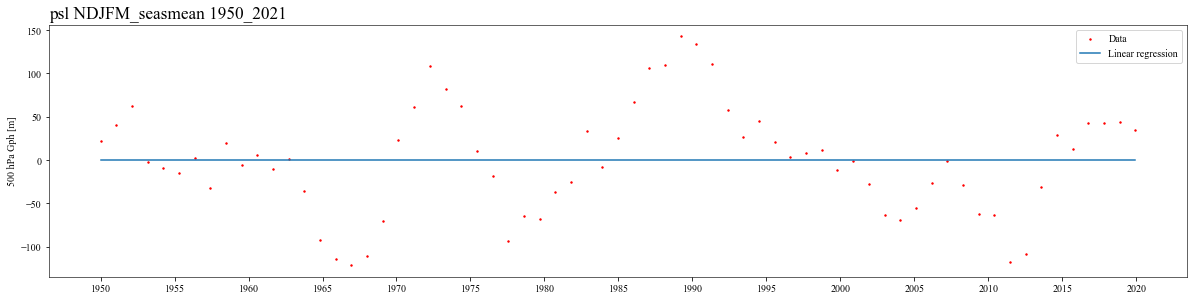

In [501]:
#Overall detrending is done with cdo detrend infile outfile
data_years=DATA_YEARS

var_name='psl'


#not-detrended data
data=os.path.join(WORKDIR, DATA_SET, 'detrended', var_name, 'data', 'ERA5_monthly_means_1950_2021_psl_NA_NDJFM_seasmean_5_yrs_runmean.nc')


dat = Dataset(data)
lats = dat.variables['lat'][:]
lons = dat.variables['lon'][:]
tims = dat.variables['time'][:]
var = dat.variables[var_name][:]
dat.close()

print(f' Shape data:  {np.shape(var)}')

mon=len(var[:])/71

myxaxis = np.arange(len(var[:,36,81]))

m,b = np.polyfit(myxaxis, var[:,36,81],1)

#d_var=detrend(var[:,250,170])

#d_var += b #scale data back

#print(f' Shape data:  {np.shape(d_var)}')

#n,c = np.polyfit(myxaxis, d_var[:],1)

print(m)

#plot

fig = plt.figure(figsize= [20.4, 4.8])
ax = plt.axes(facecolor='white')

ax.scatter(myxaxis, var[:,36,81], s=2, c='red', label='Data')
plt.plot(myxaxis, m*myxaxis+b, label='Linear regression')
#ax.scatter(myxaxis, d_var[:,], s=2, c='blue', label='Trend corrected Data')
#plt.plot(myxaxis, n*myxaxis+c, c='blue', label='Linear least-square fit')
myticks = np.arange(0,len(myxaxis),5*mon);
mylabels = np.arange(1950,2021,5) 
ax.set_xticks(ticks=myticks); 
ax.set_xticklabels(labels=mylabels);
ax.margins(x=0.005, y=0)
ax.set_title(f''+var_name+' '+month+' '+data_years+'', loc='left', fontsize='xx-large');
plt.ylabel('500 hPa Gph [m]')
plt.legend(facecolor='white')
plt.margins(0.05)
plt.subplots_adjust(bottom=0.15)
#ax.set_facecolor('white')  
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.6)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(0.6)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(0.6)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.6)

#fig.savefig(os.path.join(WORKDIR, DATA_SET, pre, ind_var, 'results', 'Detrend_'+DATA_YEARS+'_'+ind_var+'_'+month+'.pdf'), format='pdf') 

50th Percentile

-0.00011151185941614923
0.00014781461368963675
 Wet years:  [1952 1958 1962 1966 1967 1968 1970 1977 1978 1981 1983 1988 1995 2000
 2001 2016 2018 2020]
 Dry years:  [1954 1956 1957 1959 1963 1964 1969 1972 1976 1985 1991 1996 2003 2006
 2009 2011 2012 2017]
-0.7938873628904721
0.9075295671720698
 Warm years: [1952 1957 1959 1961 1973 1974 1975 1983 1989 1990 1992 1995 2007 2008
 2014 2015 2016 2020]
 Cold years:  [1956 1963 1966 1969 1970 1979 1980 1985 1986 1987 1994 1996 1999 2003
 2006 2010 2011 2013]


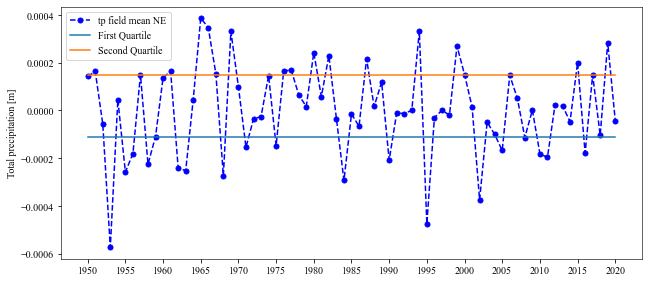

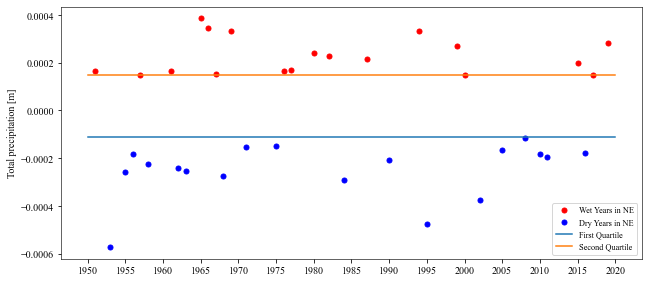

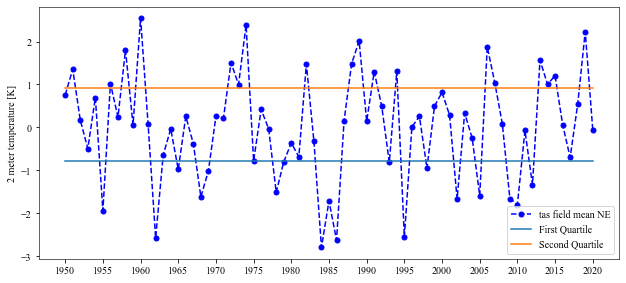

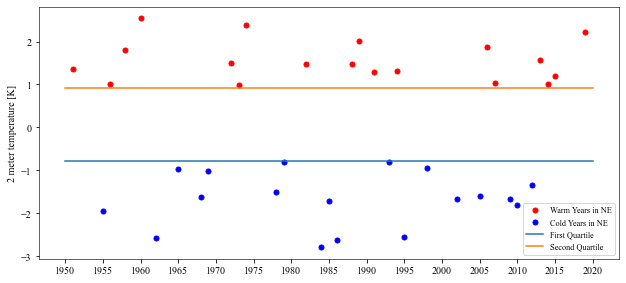

In [17]:
#Northern Europe Data

#tp

data=os.path.join(WORKDIR, DATA_SET, 'detrended', 'tp', 'data', 'masked_'+DATA_SET+'_'+DATA_TYP+'_'+DATA_YEARS+'_tp_NE_NDJFM_seasmean_fldmean'+DATA_FORMAT)
var_name=ind_var

dat = Dataset(data)
lats = dat.variables['lat'][:]
lons = dat.variables['lon'][:]
tims = dat.variables['time'][:]
var = dat.variables['tp'][:]
var_name_long = dat.variables['tp'].long_name
var_unit = dat.variables['tp'].units
dat.close()

#print(f' Shape data:  {np.shape(var)}')

mon=len(var[:])/71
myxaxis = np.arange(len(var[:]))

m,b = np.polyfit(myxaxis, var[:,0,0],1)

fig = plt.figure(figsize= [10.4, 4.8])
ax = plt.axes(facecolor='white')

tp_pctl_low = np.percentile(var, 25)
tp_pctl_high = np.percentile(var, 75)

print(tp_pctl_low)
print(tp_pctl_high)

plt.plot(myxaxis, var[:,0,0], 'bo', linestyle='dashed', markersize=5, label='tp field mean NE')
plt.plot(myxaxis, 0*myxaxis+tp_pctl_low, label='First Quartile')
plt.plot(myxaxis, 0*myxaxis+tp_pctl_high, label='Second Quartile')
myticks = np.arange(0,len(myxaxis),5*mon);
mylabels = np.arange(1950,2021,5) 
ax.set_xticks(ticks=myticks); 
ax.set_xticklabels(labels=mylabels);
ax.margins(x=0.005, y=0)
#ax.set_title(f''+var_name+' '+month+' '+data_years+'', loc='left', fontsize='xx-large');
plt.ylabel(var_name_long+' ['+var_unit+']')
plt.legend(facecolor='white')
plt.margins(0.05)
plt.subplots_adjust(bottom=0.15)
#ax.set_facecolor('white')  
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.6)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(0.6)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(0.6)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.6)

fig.savefig(os.path.join(WORKDIR, DATA_SET, 'detrended', 'tp', 'results', 'masked_Quantile_NE_'+DATA_YEARS+'_tp_'+month+'.pdf'), format='pdf') 

wet_yrs = ma.masked_less_equal(var, tp_pctl_high)
dry_yrs = ma.masked_greater_equal(var, tp_pctl_low)

mon=len(wet_yrs[:])/71 #42
myxaxis = np.arange(len(wet_yrs[:]))


fig = plt.figure(figsize= [10.4, 4.8])
ax = plt.axes(facecolor='white')

plt.plot(myxaxis, wet_yrs[:,0,0], 'ro', markersize=5, label='Wet Years in NE')
plt.plot(myxaxis, dry_yrs[:,0,0], 'bo', markersize=5, label='Dry Years in NE')
plt.plot(myxaxis, 0*myxaxis+tp_pctl_low, label='First Quartile')
plt.plot(myxaxis, 0*myxaxis+tp_pctl_high, label='Second Quartile')
myticks = np.arange(0,len(myxaxis),5*mon);
mylabels = np.arange(1950,2021,5) 
ax.set_xticks(ticks=myticks); 
ax.set_xticklabels(labels=mylabels);
ax.margins(x=0.005, y=0)
#ax.set_title(f''+var_name+' '+month+' '+data_years+'', loc='left', fontsize='xx-large');
plt.ylabel(var_name_long+' ['+var_unit+']')
plt.legend(facecolor='white', loc='lower right', fontsize='small')
plt.margins(0.05)
plt.subplots_adjust(bottom=0.15)
#ax.set_facecolor('white')  
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.6)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(0.6)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(0.6)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.6)

fig.savefig(os.path.join(WORKDIR, DATA_SET, 'detrended', 'tp', 'results', 'masked_Quantile_DW_'+DATA_YEARS+'_tp_'+month+'.pdf'), format='pdf') 

#Get the years as text

werte = (np.arange(71), np.arange(1950,2022))

wet = ma.nonzero(wet_yrs)
wet = ma.getdata(wet[0])
wet_years = np.take(werte[1][:], wet+1) #plus 1 because cdo splityear names files after the JFM of the extended winter season

print(f' Wet years:  {(wet_years)}')

dry = ma.nonzero(dry_yrs)
dry = ma.getdata(dry[0])
dry_years = np.take(werte[1][:], dry+1)

print(f' Dry years:  {(dry_years)}')

#tas

data=os.path.join(WORKDIR, DATA_SET, 'detrended', 'tas', 'data', 'masked_'+DATA_SET+'_'+DATA_TYP+'_'+DATA_YEARS+'_tas_NE_NDJFM_seasmean_fldmean'+DATA_FORMAT)
var_name=ind_var

dat = Dataset(data)
lats = dat.variables['lat'][:]
lons = dat.variables['lon'][:]
tims = dat.variables['time'][:]
var = dat.variables['tas'][:]
var_name_long = dat.variables['tas'].long_name
var_unit = dat.variables['tas'].units
dat.close()

#print(f' Shape data:  {np.shape(var)}')

mon=len(var[:])/71
myxaxis = np.arange(len(var[:]))

m,b = np.polyfit(myxaxis, var[:,0,0],1)

fig = plt.figure(figsize= [10.4, 4.8])
ax = plt.axes(facecolor='white')

tas_pctl_low = np.percentile(var, 25)
tas_pctl_high = np.percentile(var, 75)

print(tas_pctl_low)
print(tas_pctl_high)

plt.plot(myxaxis, var[:,0,0], 'bo', linestyle='dashed', markersize=5, label='tas field mean NE')
plt.plot(myxaxis, 0*myxaxis+tas_pctl_low, label='First Quartile')
plt.plot(myxaxis, 0*myxaxis+tas_pctl_high, label='Second Quartile')
myticks = np.arange(0,len(myxaxis),5*mon);
mylabels = np.arange(1950,2021,5) 
ax.set_xticks(ticks=myticks); 
ax.set_xticklabels(labels=mylabels);
ax.margins(x=0.005, y=0)
#ax.set_title(f''+var_name+' '+month+' '+data_years+'', loc='left', fontsize='xx-large');
plt.ylabel(var_name_long+' ['+var_unit+']')
plt.legend(facecolor='white', loc='lower right')
plt.margins(0.05)
plt.subplots_adjust(bottom=0.15)
#ax.set_facecolor('white')  
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.6)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(0.6)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(0.6)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.6)

fig.savefig(os.path.join(WORKDIR, DATA_SET, 'detrended', 'tas', 'results', 'masked_Quartile_NE_'+DATA_YEARS+'_tas_'+month+'.pdf'), format='pdf') 

warm_yrs = ma.masked_less_equal(var, tas_pctl_high)
cold_yrs = ma.masked_greater_equal(var, tas_pctl_low)

#mon=len(wet_yrs[:])/71 #42
#myxaxis = np.arange(len(wet_yrs[:]))


fig = plt.figure(figsize= [10.4, 4.8])
ax = plt.axes(facecolor='white')

plt.plot(myxaxis, warm_yrs[:,0,0], 'ro', markersize=5, label='Warm Years in NE')
plt.plot(myxaxis, cold_yrs[:,0,0], 'bo', markersize=5, label='Cold Years in NE')
plt.plot(myxaxis, 0*myxaxis+tas_pctl_low, label='First Quartile')
plt.plot(myxaxis, 0*myxaxis+tas_pctl_high, label='Second Quartile')
myticks = np.arange(0,len(myxaxis),5*mon);
mylabels = np.arange(1950,2021,5) 
ax.set_xticks(ticks=myticks); 
ax.set_xticklabels(labels=mylabels);
ax.margins(x=0.005, y=0)
#ax.set_title(f''+var_name+' '+month+' '+data_years+'', loc='left', fontsize='xx-large');
plt.ylabel(var_name_long+' ['+var_unit+']')
plt.legend(facecolor='white', loc='lower right', fontsize='small')
plt.margins(0.05)
plt.subplots_adjust(bottom=0.15)
#ax.set_facecolor('white')  
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(0.6)
ax.spines['top'].set_color('black')
ax.spines['top'].set_linewidth(0.6)
ax.spines['right'].set_color('black')
ax.spines['right'].set_linewidth(0.6)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(0.6)

fig.savefig(os.path.join(WORKDIR, DATA_SET, 'detrended', 'tas', 'results', 'masked_Quartile_NE_DW'+DATA_YEARS+'_tas_'+month+'.pdf'), format='pdf') 

warm = ma.nonzero(warm_yrs)
warm = ma.getdata(warm[0])
warm_years = np.take(werte[1][:], warm+1)

print(f' Warm years: {(warm_years)}')

cold = ma.nonzero(cold_yrs)
cold = ma.getdata(cold[0])
cold_years = np.take(werte[1][:], cold+1)

print(f' Cold years:  {(cold_years)}')

In [60]:
#print(high_corr)


hc=np.ones_like(high_corr)

#print(hc[0])

reg_sig=reg*hc

#print(np.shape(reg_sig))

#print(reg_sig)

x = ma.array(reg_sig, fill_value=np.nan)

x.filled()

array([[[ 0.18740467,  0.18973615,  0.19134156, ...,         nan,
                 nan,         nan],
        [ 0.19705075,  0.19959598,  0.20088566, ...,         nan,
                 nan,         nan],
        [ 0.20728022,  0.21079752,  0.21217966, ...,         nan,
                 nan,  0.27623514],
        ...,
        [ 0.73749869,  0.73980015,  0.74344317, ...,  1.37989948,
          1.38282298,  1.38503905],
        [ 0.73106605,  0.73327004,  0.73550357, ...,  1.34594538,
          1.34817091,  1.35046198],
        [ 0.70853277,  0.71141817,  0.71428817, ...,  1.31063381,
          1.31003447,  1.30917586]],

       [[-0.27189328, -0.27381305, -0.27687921, ...,         nan,
                 nan,         nan],
        [-0.27706713, -0.27879389, -0.28107226, ...,         nan,
                 nan,         nan],
        [-0.28347855, -0.28848546, -0.29076091, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,  

In [166]:
eofs1=ma.masked_values(eofs, 0)

print(np.shape(eofs1))

print(eofs1)


(4, 261, 481)
[[[0.00023729295990314772 0.000242115980810745 0.00024742014367482777
   ... 0.0007376304311505608 0.0007214654560187184 0.0007008815525320382]
  [0.00023122642223540326 0.00023629600932975373 0.00024026576406172047
   ... 0.0007417212414273529 0.0007301522967123318 0.000699991856918633]
  [0.00022639898405178407 0.00022967354336778838 0.00023348674021387794
   ... 0.0007458689634523408 0.0007265879978013719 0.0006959985685498512]
  ...
  [-0.0017613435550526506 -0.0017618614745172258 -0.0017622962860016863
   ... -0.0018559842260895982 -0.0018545411935796533
   -0.0018530910276857528]
  [-0.0017229911759717655 -0.0017234340882499345 -0.0017238551456673214
   ... -0.00180928274335682 -0.001807912127894562 -0.001806600552656613]
  [-0.0016844746912330394 -0.0016848665764843185 -0.0016851941189157545
   ... -0.0017613428193969365 -0.0017601019027038247
   -0.0017588916625349868]]

 [[-0.00019513601720689858 -0.0002099218287350029
   -0.00022528712697845153 ... 1.57381260369